# Natural Language Processing Tweets
By Wei Yu (David) Wang, DTSA 5511, April 2024

### Required modules 

In [51]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

from tensorflow.keras import layers
import keras_tuner
from keras_tuner import RandomSearch

import random
import matplotlib.pyplot as plt

## Project Objective

The primary aim of this project is to develop a tweet classifier using Natural Language Processing (NLP) techniques and Recurrent Neural Networks (RNNs). This classifier will distinguish tweets related to disasters from non-disaster tweets.

### Potential Applications
A real-life company in this field is Dataminr, which detects the earliest signals of high-impact events and emerging risks from within publicly available data.
1. Early Warning System: The classifier can serve as an alert mechanism by identifying disaster-related tweets before official news reports are available, providing a crucial advantage in timely disaster response.
2. Active Crisis Monitoring: By filtering and isolating tweets related to disasters, the system offers authorities a real-time information stream. This capability eliminates the need for manual searches across potentially diverse and numerous hashtags.


### Data Source

This project utilizes datasets from the [NLP with Disaster Tweets Kaggle competition](https://www.kaggle.com/competitions/nlp-getting-started/). These datasets will be instrumental in training and testing our model.


## Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data

### Loading the data

In [52]:
# Step 1: Loading training data
df = pd.read_csv('train.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [53]:
# Step 2: Preprocessing
texts = df['text'].apply(lambda x: x.lower())  # simple cleaning converting text to lower case
targets = df['target']

len(texts)

7613

It looks like there are 7613 training tweets

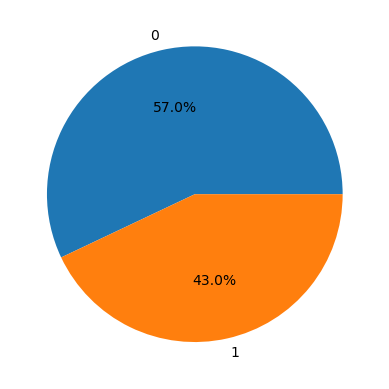

In [54]:
# checking if there is a significant training class imbalance

unique_labels, counts = np.unique(df.target.values, return_counts=True)
plt.pie(counts/np.sum(counts), labels=unique_labels, autopct='%1.1f%%')
plt.show()

It looks like there is a good balance of non-disaster and disaster related tweets.

In [55]:
# Selecting n random items from the list
random_items = random.sample(texts.to_list(), 60)

# Printing the random items
for item in random_items:
    print(" ")
    print(item)

 
holy moly that was crushed.
 
the cryptic words that guided pilots on the hiroshima bombing mission http://t.co/fce0k1ihti
 
@fewmoretweets all lives matter. just not a fan of burning down buildings and stealing from your neighbors to 'protest'
 
i hate that im so awkward and i ruin things
 
a dayton-area org tells me it was hit by a cyber attack: http://t.co/7lhkjz0ivo
 
downtown emergency service center is hiring! #chemical #dependency counselor or intern in #seattle apply now! #jobs http://t.co/hhtwayt4yo
 
jacksonville  family bands together as memorial is planned for  ... http://t.co/tilgurkv7z
 
@deosl86 @xavier_marquis hostages are meaningless might as well just play cod search and destroy.
 
read an eyewitness account from #hiroshima from this day in 1945 http://t.co/quedv2xxxx #life
 
@samajp32 really needs to tone it down some in the weight room. rt @soonersportstv: demolition (cont) http://t.co/2o7eva1coe
 
nbanews soudelor typhoon soudelor is taking dead aim at taiwan and

Observations: While there are links, they are likely unique and unlikely to affect deep learning. If they are not unique and have occurred multiple times, they could be an important source of information such as "Rickroll" link for pranks or specific reports on a news site. Twitter handles should not be removed, people could be tweeting to a natural disaster expert, journalist, government etc... if the handles occur multiple times for real disasters or to celebrities for fake disasters such as relating to a bad movie.

Because of how short a tweet is, most of the text information should be kept or else we're left with only a few words

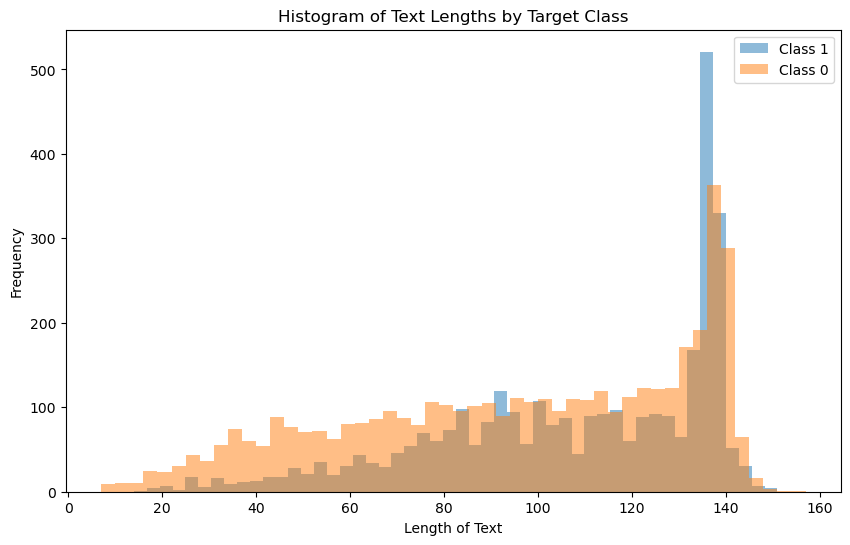

In [56]:
# Are disaster tweets shorter of longer than non-disaster tweets?

df['text_length'] = df['text'].apply(len)

# Create the histogram
plt.figure(figsize=(10, 6))
for label in df['target'].unique():
    subset = df[df['target'] == label]
    plt.hist(subset['text_length'], bins=50, alpha=0.5, label=f'Class {label}')

plt.title('Histogram of Text Lengths by Target Class')
plt.xlabel('Length of Text')
plt.ylabel('Frequency')
plt.legend()
plt.show()

Generally real disasters are longer but they are still very similar in character length. 

## Model Architecture
## Data Preprocessing

### Word Embeddings
The Tokenizer class from the Keras library is used to preprocess text data for training in machine learning models, particularly for natural language processing (NLP) tasks. I chose the default Kerase tokenizer for direct use in neural network models where custom training or leveraging Keras’s built-in functionalities is desired.

TF-IDF might be better for tasks focused on keyword significance across documents.but may not capture the nuances of language due to its ignorance of word order and semantics. In this case, it is not useful because the keyword columns are already included and are not good determinants if a tweet is a disaster or not.

Word2Vec can be used if contextual subtleties are less critical, but may not handle polysemy (words with multiple meanings) effectively which occurs frequently in this dataset (Instagram on fire vs forest on fire). 

In [57]:
# Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
print(f'Found {len(word_index)} unique tokens.')

# Padding
data = pad_sequences(sequences, maxlen=100)  # assuming tweets are no longer than 100 words

Found 22700 unique tokens.


## Model Building

## Model Building

The provided model is structured using Keras, a popular deep learning framework, and is designed for classifying tweets into two categories: tweets about a real disaster and those that are not. The architecture of this model combines several components that make it particularly effective for this task. Here's an explanation of each component and its role:

1. **Embedding Layer**
   - **Purpose:** Maps each word index to a dense vector of fixed size (embedding_dim). This vector seeks to capture semantic properties of words, where similar words have similar encoding.
   - **Effectiveness:** For tweet classification, embeddings help capture the contextual meanings of words in a lower-dimensional space. Given that tweets are short, capturing subtle semantic cues is crucial, and embeddings provide a way to do this efficiently.

2. **LSTM Layers**
   - **Configuration:**
     - The first LSTM layer has 64 units and returns sequences. This means it outputs the hidden state for each time step, allowing the next LSTM layer to capture information from the entire sequence.
     - The second LSTM layer has 32 units and does not return sequences, meaning it only returns the output of the last time step.
   - **Purpose:** Long Short-Term Memory (LSTM) networks are a type of recurrent neural network (RNN) capable of learning order dependence in sequence prediction problems.
   - **Effectiveness:** LSTMs are particularly suited for classification based on the sequence of words in tweets. They can capture temporal dependencies and nuances in the text data, which are important for understanding the context in which words are used (e.g., distinguishing a literal disaster from a metaphorical one).

3. **Dense and Dropout Layers**
   - **Dense Layers:**
     - The first dense layer has 32 neurons and uses ReLU (rectified linear unit) activation, a common choice for introducing non-linearity into the model, helping it learn more complex patterns.
     - The final dense layer with a single neuron and sigmoid activation outputs a probability indicating the likelihood of the tweet being about a real disaster.
   - **Dropout Layer:**
     - A dropout rate of 0.5 is used, which randomly sets the output features of 50% of the neurons to zero during training. This prevents overfitting by ensuring that the model does not rely too heavily on any particular neuron, promoting generalization.
   - **Effectiveness:** The combination of dense layers for pattern recognition and dropout for regularization is effective in managing the complexity and variance in the data, helping to avoid overfitting especially in a dataset that might not be very large.

4. **Compilation**
   - **Optimizer:** 'adam' is an adaptive learning rate optimizer known for its effectiveness in different kinds of deep learning models, making it a robust choice for training.
   - **Loss Function:** 'binary_crossentropy' is appropriate for binary classification tasks, directly targeting the minimization of errors in a probabilistic context, which is exactly the goal when predicting whether a tweet is about a real disaster or not.
   - **Metrics:** 'accuracy' is a straightforward and interpretable metric for classification tasks, helping to assess the percentage of correct predictions.

In [58]:
# Parameters
vocab_size = len(word_index) + 1  # Adding 1 because index 0 is not used
embedding_dim = 50  # Dimension of the embedding vector

# Building the model
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim),
    LSTM(64, return_sequences=True),
    LSTM(32),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 50)          1135050   
                                                                 
 lstm_5 (LSTM)               (None, None, 64)          29440     
                                                                 
 lstm_6 (LSTM)               (None, 32)                12416     
                                                                 
 dense_4 (Dense)             (None, 32)                1056      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1177995 (4.49 MB)
Trainable params: 1177

In [59]:
# Step 4: Split data and train the model
X_train, X_test, y_train, y_test = train_test_split(data, targets, test_size=0.2, random_state=42)
simple_model = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test))

# Step 5: Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {accuracy}')

Epoch 1/5
96/96 [==============================] - 30s 196ms/step - loss: 0.6077 - accuracy: 0.6724 - val_loss: 0.4702 - val_accuracy: 0.7866
Epoch 2/5
96/96 [==============================] - 17s 173ms/step - loss: 0.3477 - accuracy: 0.8685 - val_loss: 0.4720 - val_accuracy: 0.7873
Epoch 3/5
96/96 [==============================] - 17s 177ms/step - loss: 0.1843 - accuracy: 0.9404 - val_loss: 0.6112 - val_accuracy: 0.7886
Epoch 4/5
96/96 [==============================] - 16s 162ms/step - loss: 0.0943 - accuracy: 0.9688 - val_loss: 0.8018 - val_accuracy: 0.7354
Epoch 5/5
48/48 [==============================] - 1s 28ms/step - loss: 0.8921 - accuracy: 0.7439
Test accuracy: 0.743926465511322


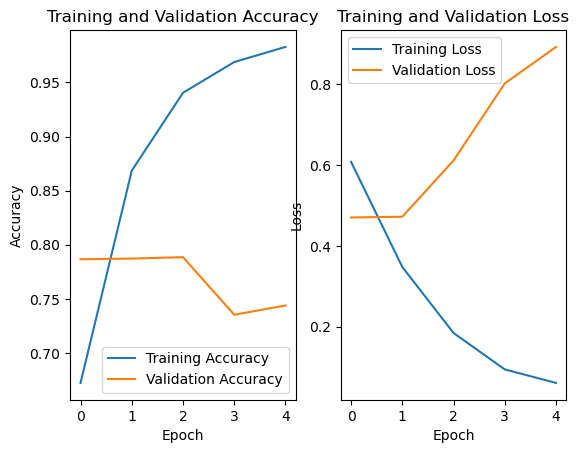

In [64]:
# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(simple_model.history['accuracy'], label='Training Accuracy')
plt.plot(simple_model.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(simple_model.history['loss'], label='Training Loss')
plt.plot(simple_model.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

### Overall Effectiveness

At a validation accuracy of approximately 79%, this model is well-suited for the task of classifying tweets about real disasters because it integrates powerful NLP components (like word embeddings and LSTMs) to effectively capture and utilize the semantic and syntactic structure of language in tweets. Additionally, it includes mechanisms (like dropout and sigmoid activation) to manage overfitting and to produce probabilistic outputs, respectively, enhancing its predictive capabilities and robustness. From the charts, it can be seen that additional epoches leads to overfitting with an increase in training accuracy and a decrease in validation accuracy. 

## Results and Analysis
### Model Tuning

Because this is a mini-project and the goal is not to reach the top result on Kaggle, I used RandomSearch(), which is a method for hyperparameter tuning in machine learning models. This method is used to find the best parameters for a model, helping improve its performance on given tasks.

Random Search is an alternative to Grid Search for hyperparameter optimization. Instead of systematically testing all possible combinations of parameters (as in Grid Search), Random Search selects random combinations of parameters to test. This approach can be more efficient when dealing with a large number of hyperparameters or when the hyperparameters are expected to have non-uniform influence on the model performance.

In [18]:
def build_model(hp):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=hp.Int('embedding_dim', min_value=32, max_value=128, step=32)))
    
    for i in range(hp.Int('num_lstm_layers', 1, 3)):
        model.add(LSTM(units=hp.Int('units_lstm_' + str(i), min_value=32, max_value=128, step=32), return_sequences=True))
    model.add(LSTM(units=hp.Int('units_lstm_final', min_value=32, max_value=128, step=32), return_sequences=False))
    
    model.add(Dropout(rate=hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)))
    
    model.add(Dense(units=hp.Int('units_dense', min_value=32, max_value=128, step=32), activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer=hp.Choice('optimizer', ['adam', 'rmsprop']),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [19]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,  # number of model configurations to try
    executions_per_trial=1,  # number of models to build and fit for each trial
    directory='model_tuning',
    project_name='DisasterTweetClassification'
)

# Display search space summary
tuner.search_space_summary()


Search space summary
Default search space size: 7
embedding_dim (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': 'linear'}
num_lstm_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
units_lstm_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': 'linear'}
units_lstm_final (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': 'linear'}
dropout (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
units_dense (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': 'linear'}
optimizer (Choice)
{'default': 'adam', 'conditions': [], 'values': ['adam', 'rmsprop'], 'ordered': False}


In [20]:
tuner.search(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

Trial 10 Complete [00h 02m 27s]
val_accuracy: 0.8095863461494446

Best val_accuracy So Far: 0.813525915145874
Total elapsed time: 00h 23m 44s


In [21]:
best_model = tuner.get_best_models(num_models=1)[0]
loss, accuracy = best_model.evaluate(X_test, y_test)
print("Best model accuracy: ", accuracy)

48/48 [==============================] - 5s 41ms/step - loss: 0.4360 - accuracy: 0.8135
Best model accuracy:  0.813525915145874


In [23]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          1452864   
                                                                 
 lstm (LSTM)                 (None, None, 32)          12416     
                                                                 
 lstm_1 (LSTM)               (None, None, 96)          49536     
                                                                 
 lstm_2 (LSTM)               (None, 64)                41216     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 1)                 1

In [65]:
tuner.results_summary()

Results summary
Results in model_tuning\DisasterTweetClassification
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 04 summary
Hyperparameters:
embedding_dim: 64
num_lstm_layers: 2
units_lstm_0: 32
units_lstm_final: 64
dropout: 0.0
units_dense: 128
optimizer: rmsprop
units_lstm_1: 96
units_lstm_2: 96
Score: 0.813525915145874

Trial 06 summary
Hyperparameters:
embedding_dim: 64
num_lstm_layers: 1
units_lstm_0: 64
units_lstm_final: 128
dropout: 0.30000000000000004
units_dense: 96
optimizer: rmsprop
units_lstm_1: 96
units_lstm_2: 64
Score: 0.8122127652168274

Trial 05 summary
Hyperparameters:
embedding_dim: 128
num_lstm_layers: 3
units_lstm_0: 64
units_lstm_final: 32
dropout: 0.1
units_dense: 64
optimizer: rmsprop
units_lstm_1: 64
units_lstm_2: 64
Score: 0.810899555683136

Trial 09 summary
Hyperparameters:
embedding_dim: 32
num_lstm_layers: 3
units_lstm_0: 64
units_lstm_final: 32
dropout: 0.1
units_dense: 128
optimizer: rmsprop
units_lstm_1: 96
units_lstm_2: 

In [70]:
import pandas as pd

# Define data for each trial as a dictionary, then compile them into a DataFrame
data = {
    "Trial ID": ["04", "06", "05", "09", "01", "00", "08", "02", "07", "03"],
    "Embedding Dim": [64, 64, 128, 32, 96, 64, 32, 32, 128, 32],
    "Num LSTM Layers": [2, 1, 3, 3, 3, 1, 2, 3, 3, 1],
    "Units LSTM 0": [32, 64, 64, 64, 64, 64, 128, 64, 96, 96],
    "Units LSTM Final": [64, 128, 32, 32, 64, 128, 96, 96, 64, 128],
    "Dropout": [0.0, 0.3, 0.1, 0.1, 0.0, 0.1, 0.0, 0.0, 0.4, 0.3],
    "Units Dense": [128, 96, 64, 128, 96, 128, 96, 96, 96, 64],
    "Optimizer": ["rmsprop", "rmsprop", "rmsprop", "rmsprop", "adam", "rmsprop", "adam", "rmsprop", "rmsprop", "adam"],
    "Units LSTM 1": [96, 96, 64, 96, 32, None, 32, 96, 32, 32],
    "Units LSTM 2": [96, 64, 64, 64, 32, None, 64, 96, 32, 32],
    "Score": [0.8135, 0.8122, 0.8109, 0.8096, 0.8083, 0.8056, 0.8043, 0.7997, 0.7997, 0.7853]
}

# Create the DataFrame
results_df = pd.DataFrame(data)

# Print the DataFrame
results_df.sort_values(by='Trial ID')

# Optimization Results Table

,Trial ID,Embedding Dim,Num LSTM Layers,Units LSTM 0,Units LSTM Final,Dropout,Units Dense,Optimizer,Units LSTM 1,Units LSTM 2,Score
5,00,64,1,64,128,0.1,128,rmsprop,NaN,NaN,0.8056
4,01,96,3,64,64,0.0,96,adam,32.0,32.0,0.8083
7,02,32,3,64,96,0.0,96,rmsprop,96.0,96.0,0.7997
9,03,32,1,96,128,0.3,64,adam,32.0,32.0,0.7853
0,04,64,2,32,64,0.0,128,rmsprop,96.0,96.0,0.8135
2,05,128,3,64,32,0.1,64,rmsprop,64.0,64.0,0.8109
1,06,64,1,64,128,0.3,96,rmsprop,96.0,64.0,0.8122
8,07,128,3,96,64,0.4,96,rmsprop,32.0,32.0,0.7997
6,08,32,2,128,96,0.0,96,adam,32.0,64.0,0.8043
3,09,32,3,64,32,0.1,128,rmsprop,96.0,64.0,0.8096


# Analysis of Top Performing Trials

## Overview
I'll dive into why certain trial configurations like Trial 04 stood out among the rest. Let's unpack the key elements that contributed to its success and compare it with other high-ranking trials.

### Key Observations

#### Trial 04 (Best Score: 0.8135)
- Embedding Dimension: 64
- Number of LSTM Layers: 2
- LSTM Units: Configured as 32 in the first layer, followed by 96 in the next two layers.
- Dropout: 0.0 (no dropout applied)
- Dense Units: 128
- Optimizer: RMSprop

Insights:
- The lack of dropout and a balanced approach to the number of LSTM units across layers likely led to its high performance. RMSprop, known for its robustness against noisy gradients, seems to have been a key factor as well.

#### Other Top Trials (e.g., Trial 06, Trial 05)
- Embedding Dimensions: Used both 64 and 128 without consistent effects, suggesting flexibility within this range.
- Number of LSTM Layers: 1 to 3 layers were tested. The best results were seen with 2 layers, indicating more layers aren’t always better.
- Dropout: Varied from 0.0 to 0.3, with mixed results. The top performing trials didn't use dropout, hinting that it may not be necessary for this dataset.

## Why Certain Configurations Worked Well

- LSTM Units: Having a just-right number of LSTM units seems to hit the sweet spot—enough to learn effectively without overfitting or underperforming.
- Dropout: The best trial skipping dropout suggests the model performed best when learning from all available information during each learning phase.
- Optimizer: RMSprop kept showing up in the mix of better-performing trials, possibly due to its adept handling of LSTM’s noisy gradients.

## Hyperparameter Optimization Procedure Summary

RandomSearch Method:
- I set up a search space that included parameters like embedding dimensions, LSTM layer count, unit configurations, dropout rates, dense units, and optimizer types.
- I mixed and matched these parameters in 10 different trials, aiming to nail down the best model based on how well it did on a validation set.

# Conclusion

Using RandomSearch, I discovered that sometimes simpler is better. The standout model had just two LSTM layers and zero dropout, with RMSprop steering the ship. This setup shows that even a random search can reveal unexpectedly effective models, balancing complexity and generalization capabilities based on real-world performance rather than just theory. All of these models performed similarily to the simple model first created as well as each other.

In cases where dropout was used, no clear benefit was observed. This suggests that dropout, which is typically employed to prevent overfitting, was either unnecessary due to the model not being prone to overfitting with the given data and configurations, or it was detrimental by impeding the model's ability to learn from the full set of features.

While variations in embedding dimensions (ranging from 64 to 128) didn’t show a consistent advantage, it suggests that within this range, the choice of dimensionality was less critical to performance, possibly due to the model's ability to adapt to the provided information capacity.

### Future Improvements

While dropout did not show benefits, other regularization methods like L1/L2 regularization or advanced techniques such as Batch Normalization could be explored to see if they offer any improvement without the drawbacks observed with dropout.

Incorporating learning rate schedules or using optimizers like Adam, which adjust the learning rate dynamically, might yield improvements, especially in convergence speed and handling data with varying scales and complexities.

Beyond traditional LSTMs, other RNN architectures like GRU (Gated Recurrent Unit) or even bidirectional RNNs might provide different benefits, balancing computational efficiency and model performance.

More word embedding techniques and data preprocessing techniques could be explored and how they affect model performance.

In [83]:
# Kaggle Prediction

# Predict
predict_dataset = pd.read_csv('test.csv')
predict_text = predict_dataset['text']

# Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(predict_text)
sequences = tokenizer.texts_to_sequences(predict_text)
word_index = tokenizer.word_index
print(f'Found {len(word_index)} unique tokens.')

# Padding
data = pad_sequences(sequences, maxlen=100)  # assuming tweets are no longer than 100 words
predictions = best_model.predict(data)

Found 12818 unique tokens.
102/102 [==============================] - 11s 71ms/step


In [84]:
predicted_classes = (predictions > 0.5).astype(int)
predict_dataset['target'] = predicted_classes
output = predict_dataset.drop(columns=['keyword', 'location', 'text'])
output.to_csv('NLP_4_Submission.csv', index = False)

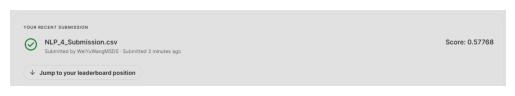

In [87]:
import matplotlib.image as mpimg

img = mpimg.imread('kaggle_results.png')
plt.imshow(img)
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()

This is significantly worse than my validation score. It looks like there is overfitting in my model. I suspected this to be the case when the validation accuracy decreased with an increase in epochs at 3. 